# Over Under Predictor

## Modeling Notebook

In [129]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
from sklearn.model_selection import cross_val_score
import re
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
pd.set_option('display.max_columns', 100)

In [130]:
df = pd.read_csv('data/final_df.csv')

# Feature Engineering

In [131]:
# Drop Uneeded Rows
df = df.drop(columns=['unix', 'time','stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION','team_away','team_home',
                      'LATITUDE','LONGITUDE','zipcode','zipcode_away','stadium_name','team_favorite_id','stadium_location'])

#'away_MoV','home_MoV','diff_MoV','diff_OSRS','away_SRS','home_SRS',
#'diff_SRS','away_OSRS','away_PD','home_OSRS','home_PD','away_DSRS','home_DSRS'
 

df.drop(columns=['score_home','score_away','total'],inplace=True)
df.drop('schedule_date', axis=1,inplace=True)

# Transform Over/Under Results to Binary 0 = Under, 1 = Over
df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)
# Transform Stadium Surface to Binary 0 = Turf, 1 = Grass 
df['stadium_surface'] = np.where(df['stadium_surface'] == 'Grass',1,0)

# True/False to Binary 0 = False, 1 = True
df['schedule_playoff'] = list(map(int, df['schedule_playoff']))
df['stadium_neutral'] = list(map(int, df['stadium_neutral']))

# Get Dummies for Categorical Variables
df = pd.get_dummies(df, columns = ['icon'], drop_first= True)
df = pd.get_dummies(df, columns = ['summary'], drop_first= True)
df = pd.get_dummies(df, columns = ['stadium_type'], drop_first= True)
#df = pd.get_dummies(df, columns = ['stadium_name'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_home'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_away'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_favorite_id'], drop_first= True)

# Transform Uint8 values to Integers
uint8_columns = list(df.select_dtypes('uint8').columns)
for colname in df.columns:
    if colname in uint8_columns:
        df[colname] = df[colname].astype(int)

# Drop the last couple Null Values
df = df.dropna()

In [132]:
### Percentages of Classes ###
print("Total 'Under' Outcomes")
print(df.over_under_result.value_counts()[0])
print("Total 'Over' Outcomes")
print(df.over_under_result.value_counts()[1])
print('----------------------------------------')
print("Percent 'Under' Outcomes")
print(round((df.groupby(['over_under_result']).over_under_result.count()[0]/
       df.groupby(['over_under_result']).over_under_result.count().sum()),2))
print("Percent 'Over' Outcomes")
print(round((df.groupby(['over_under_result']).over_under_result.count()[1]/
       df.groupby(['over_under_result']).over_under_result.count().sum()),2))

Total 'Under' Outcomes
4978
Total 'Over' Outcomes
4837
----------------------------------------
Percent 'Under' Outcomes
0.51
Percent 'Over' Outcomes
0.49


# Feature Selection

In [133]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('over_under_result', axis=1) # grabs everything else but 'Default'

# Create target variable
y = df['over_under_result'] # y is the column we're trying to predict

Check to see which features correlate highly with our Target Variable

In [134]:
np.abs(df.corr()['over_under_result']).sort_values(ascending=False)

over_under_result                        1.000000
over_under_line                          0.027211
precipIntensity                          0.025543
windSpeed                                0.025436
summary_Heavy Rain and Humid             0.025092
                                           ...   
stadium_neutral                          0.000712
summary_Light Rain and Humid             0.000681
summary_Possible Light Rain and Humid    0.000581
stadium_type_retractable                 0.000320
summary_Heavy Snow                       0.000290
Name: over_under_result, Length: 106, dtype: float64

# Baseline Models

To start modeling I will use some baseline models to start to understand which are the best algorithms to use with my data, to start I will use four baseline models; Logistic Regression, Decision Tree, Random Forest, and Support Vector Machine.

### Train Test Split

We first need to start with splitting our data. We split our data into a Train and Test set. 75% of our data goes into the Train set, which we will use to fit our model. 25% of our data goes into Test set, which we use to predict our target variable.

In [135]:
#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=20)

### Scale Data

In [136]:
# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = X.columns)

### Logistic Regression

In [137]:
from sklearn.linear_model import LogisticRegression

base_logreg = LogisticRegression(class_weight = 'balanced')

base_logreg.fit(X_train, y_train)

base_logred_train_pred = base_logreg.predict(X_train)
base_logred_test_pred = base_logreg.predict(X_test)

base_logred_train_f1_score = round(f1_score(y_train, base_logred_train_pred),3)
base_logreg_test_f1_score = round(f1_score(y_test, base_logred_test_pred),3)

print('Train F1 score: ', base_logred_train_f1_score)
print('Test F1 score: ', base_logreg_test_f1_score)


Train F1 score:  0.552
Test F1 score:  0.532


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [167]:
scores = cross_val_score(base_logreg, X, y, scoring="f1", cv = 10)
mean_score = scores.mean()
std_score = scores.std()
print(scores)
print(mean_score)
print(std_score)

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

[0.49689441 0.51669941 0.53754941 0.49652433 0.5        0.46237732
 0.46945338 0.51244813 0.48728814 0.43838604]
0.49176205607114226
0.02737390350872659


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

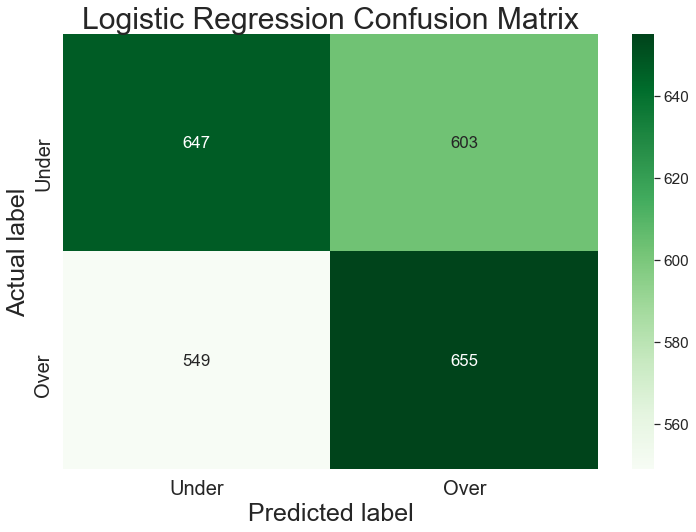

In [138]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, base_logred_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Logistic Regression Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
plt.savefig('log_confusion.png')

Starting with a basic Logistic Regression model with a balanced class imbalance we recieved an F1 Score of .484. As a basis we are shooting for atleast above 51%, which we could achieve by predicting 'Under' everytime. We can see from our confusion matrix that the model is overpredicting 'Under' compared to 'Over'. The model is performing poorly on both the Train and the Test Dataset which could point to underfitting.

### Decision Tree

In [140]:
# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

dtc_train_pred = dtc.predict(X_train)
dtc_test_pred = dtc.predict(X_test)

dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', dtc_f1_train)
print('Test F1 score: ', dtc_f1_test)


Train F1 score:  1.0
Test F1 score:  0.513


In [141]:
scores = cross_val_score(dtc, X, y, scoring="f1", cv = 5)
mean_score = scores.mean()
std_score = scores.std()
print(scores)
print(mean_score)
print(std_score)

[0.50920568 0.48662551 0.50892402 0.49796748 0.49360341]
0.4992652210340678
0.008781884966810318


The Cross Validation score shows that the F1 score is hovering around 50%. We will have to try to continue to tune hyperparameters to improve the score.

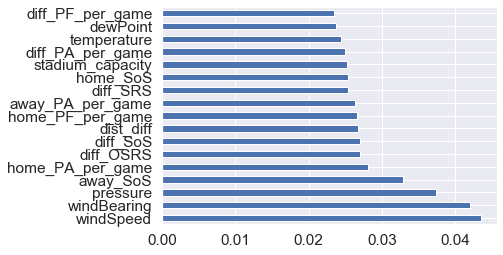

In [142]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

feat_importances = pd.Series(dtc.feature_importances_, index=X.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

Above we can see some of the most important features driving our Decision Tree Classifer

[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

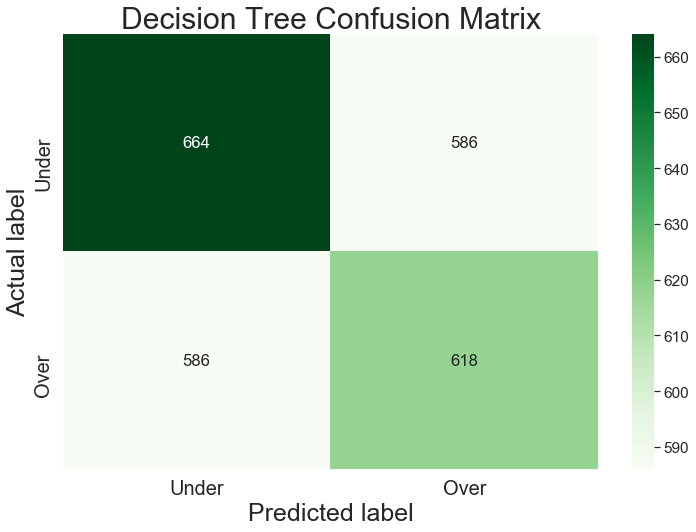

In [143]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, dtc_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Decision Tree Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

Our Decision Tree Classifier is overfit, but our Test F1 score is still an improvement compared to our Logistic Regression Model. We can see from form our Confusion Matric that we are slightly overpredicting the 'Under'. Now I will run a Grid Search CV to trying and further tune the hyperperameters of the Decision Tree Model to see if we can improve our baseline.

In [144]:
from sklearn.model_selection import GridSearchCV
# find the best hyperparameters for simple decision tree
parameters={'max_depth': range(3,10,1),  
            'min_samples_split':range(1,10,1),
            'min_samples_leaf':range(1,10,1),
            'criterion': ['gini'] 
           }

dtc = DecisionTreeClassifier(random_state=1)

tree_g = GridSearchCV(dtc, parameters, cv=5, scoring='f1', verbose = 1,  n_jobs = -1)
tree_g.fit(X_train,y_train)

print(tree_g.best_params_, ': ', tree_g.best_score_)

y_pred = tree_g.best_estimator_.predict(X_test)    
y_pred_train = tree_g.best_estimator_.predict(X_train)    

f1_train = round(f1_score(y_train, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Fitting 5 folds for each of 567 candidates, totalling 2835 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 2456 tasks      | elapsed:  1.2min


{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2} :  0.5312736797167067
Train F1 score:  0.58
Test F1 score:  0.525


[Parallel(n_jobs=-1)]: Done 2835 out of 2835 | elapsed:  1.6min finished


After using Gridsearch I was able to get me Decision Tree F1 score up to .547 improving by roughly 3%. I was able to do this by using 'Gini' as my criterion, a max depth of 8, minimum sample leafs of 3, minimum samples split 7. Similar to the Logistic Regression Model, the data is performing similaron the training and test sets, leading me to believe there isn't much overfitting going on.

## Random Forest

In [145]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)

print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

Train F1 score:  1.0
Test F1 score:  0.527


Text(0.5, 44.5, 'Predicted label')

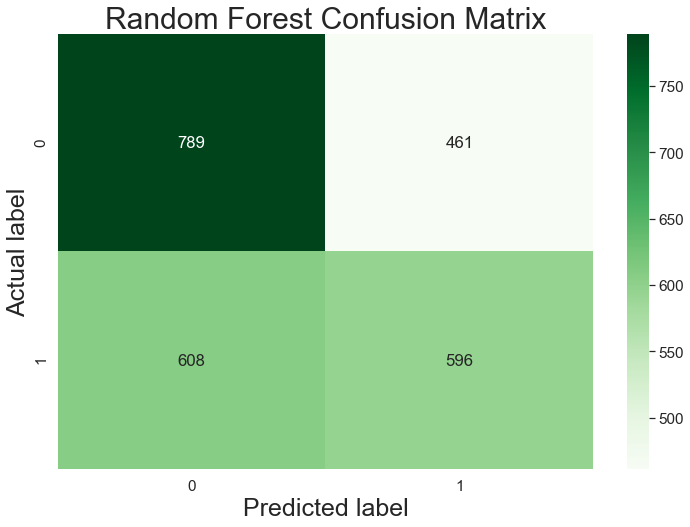

In [146]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, rfc_predicted, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Random Forest Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
#cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
#cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

Above our Random Forest model looks to be very overfit with an unsuccessful F1 score. I will try to run a gridsearch to see if there is any sign of Random Forest running successfully.

In [147]:
from sklearn.ensemble import BaggingClassifier

# find the best hyperparameters 
parameters={'n_estimators': range(50, 200, 50),
            'max_depth': range(3,8,1),
            'max_features': [0.3, 0.5, 0.7, 0.9],
            'min_samples_split':range(1,10,2),
            'criterion': ['gini', 'entropy'] 
           }

forest = RandomForestClassifier()

tree_g = GridSearchCV(forest, parameters, cv=5, scoring='f1', verbose = 1,  n_jobs = -1)
tree_g.fit(X_train,y_train)

print(tree_g.best_params_, ': ', tree_g.best_score_)

y_pred = tree_g.best_estimator_.predict(X_test)    
y_pred_train = tree_g.best_estimator_.predict(X_train)    

f1_train = round(f1_score(y_train, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
After the gridsearch we see that our data 

### SVM Model

In [148]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svm = svm.SVC() # Linear Kernel

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
svm_pred = svm.predict(X_test)
svm_pred_train = svm.predict(X_train)

#Score
svm_f1_train = round(f1_score(y_train, svm_pred_train), 3)
svm_f1_test = round(f1_score(y_test, svm_pred), 3)

print('Train F1 score: ', svm_f1_train)
print('Test F1 score: ', svm_f1_test)

Train F1 score:  0.645
Test F1 score:  0.501


[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

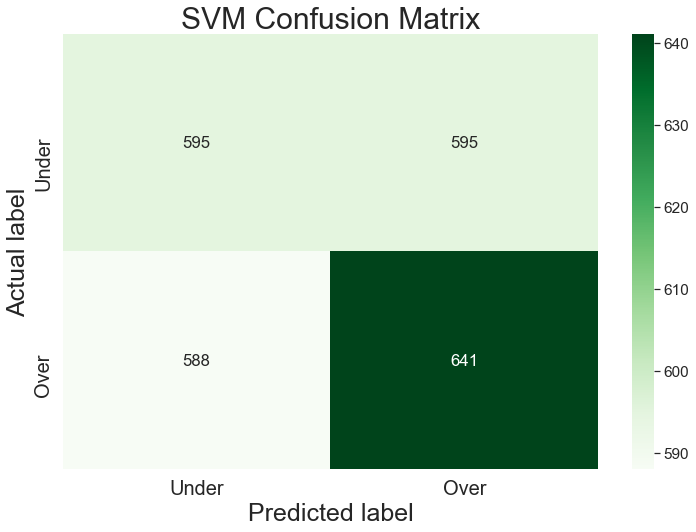

In [104]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, svm_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('SVM Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

The Support Vector Machine model did not extract great results. With a Test F1 of .489 and Train of .641 it seems that our data seems to be overfit to the training data. 

# Baseline Final Scores 

In [149]:
print('Baseline Logistic Regression:')
print('      Train F1 score: ', base_logred_train_f1_score)
print('      Test F1 score: ', base_logreg_test_f1_score)
print('')
print('Decision Tree:')
print('      Train F1 score: ', dtc_f1_train)
print('      Test F1 score: ', dtc_f1_test)
print('')
print('Random Forest:')
print('      Train F1 score: ', rfc_f1_train)
print('      Test F1 score: ', rfc_f1_test)
print('')
print('Support Vector Machine:')
print('      Train F1 score: ', svm_f1_train)
print('      Test F1 score: ', svm_f1_test)

Baseline Logistic Regression:
      Train F1 score:  0.552
      Test F1 score:  0.532

Decision Tree:
      Train F1 score:  1.0
      Test F1 score:  0.513

Random Forest:
      Train F1 score:  1.0
      Test F1 score:  0.527

Support Vector Machine:
      Train F1 score:  0.645
      Test F1 score:  0.501


The final scores of the baseline models shows that the Logistic Regression and the Decision Tree models are working the best with our data. While there is a slight overfitting simply comparing the the Test to the Train metrics, I still have plenty of room to continue overfitting and see if it will bring up my Test Scores.

# Baselines + Recursive Feature Elimination

Now I will use a Recursive Feature Elimination to try to extract the the most valuable features moving forward in our modeling process.

In [150]:
from sklearn.feature_selection import RFECV
# Create recursive feature eliminator that scores features by mean squared errors
rfc_log = RFECV(estimator=LogisticRegression(),step=1, cv=5, scoring='f1', n_jobs=-1,verbose=1)

# Fit recursive feature eliminator 
rfc_log.fit(X_train, y_train)

selected_rfe = X_train.columns[rfc_log.support_]
removed_rfe = X_train.columns[~rfc_log.support_]

Fitting estimator with 105 features.
Fitting estimator with 104 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 103 features.
Fitting estimator with 102 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 101 features.
Fitting estimator with 100 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 99 features.
Fitting estimator with 98 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 97 features.
Fitting estimator with 96 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 95 features.
Fitting estimator with 94 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 72 features.
Fitting estimator with 71 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 70 features.
Fitting estimator with 69 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 68 features.
Fitting estimator with 67 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 66 features.
Fitting estimator with 65 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 64 features.
Fitting estimator with 63 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 52 features.
Fitting estimator with 51 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 44 features.
Fitting estimator with 43 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [151]:
#Split the Data

X_train, X_test, y_train, y_test = train_test_split(X[selected_rfe], y,random_state=5)

In [152]:
# Scale the Data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = X[selected_rfe].columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = X[selected_rfe].columns)

## Logistic Regression w/ RFE

In [153]:
### Logistic Regression

logreg = LogisticRegression(class_weight = 'balanced')

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)

rfe_logred_train_f1_score = round(f1_score(y_train, base_logred_train_pred),3)
rfe_logreg_test_f1_score = round(f1_score(y_test, base_logred_test_pred),3)

print('Train F1 score: ', rfe_logred_train_f1_score)
print('Test F1 score: ', rfe_logreg_test_f1_score)


Train F1 score:  0.537
Test F1 score:  0.544


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Decision Tree w/ RFE

In [157]:
### Decision Tree

# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

dtc = DecisionTreeClassifier(random_state = 1,
                             criterion= 'gini',
                             max_depth= 5,
                             min_samples_leaf= 6,
                             min_samples_split= 2)
dtc.fit(X_train, y_train)

dtc_train_pred = dtc.predict(X_train)
dtc_test_pred = dtc.predict(X_test)

rfe_dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
rfe_dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', rfe_dtc_f1_train)
print('Test F1 score: ', rfe_dtc_f1_test)



Train F1 score:  0.599
Test F1 score:  0.564


## Random Forest w/ RFE

In [159]:
### Random Forest

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_recall_score = metrics.recall_score(y_test, rfc_predicted)

rfe_rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
rfe_rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)

print('Train F1 score: ', rfe_rfc_f1_train)
print('Test F1 score: ', rfe_rfc_f1_test)

Train F1 score:  0.575
Test F1 score:  0.446


## SVM w/ RFE

In [160]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svm = svm.SVC() # Linear Kernel

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
svm_pred = svm.predict(X_test)
svm_pred_train = svm.predict(X_train)

#Score
rfe_svm_f1_train = round(f1_score(y_train, svm_pred_train), 3)
rfe_svm_f1_test = round(f1_score(y_test, svm_pred), 3)

print('Train F1 score: ', rfe_svm_f1_train)
print('Test F1 score: ', rfe_svm_f1_test)

Train F1 score:  0.602
Test F1 score:  0.511


In [161]:
### Final Scores 

print('Logistic Regression:')
print('      Train F1 score: ', rfe_logred_train_f1_score)
print('      Test F1 score: ', rfe_logreg_test_f1_score)
print('')
print('Decision Tree:')
print('      Train F1 score: ', rfe_dtc_f1_train)
print('      Test F1 score: ', rfe_dtc_f1_test)
print('')
print('Random Forest:')
print('      Train F1 score: ', rfe_rfc_f1_train)
print('      Test F1 score: ', rfe_rfc_f1_test)
print('')
print('Support Vector Machine:')
print('      Train F1 score: ', rfe_svm_f1_train)
print('      Test F1 score: ', rfe_svm_f1_test)

Baseline Logistic Regression:
      Train F1 score:  0.537
      Test F1 score:  0.544

Decision Tree:
      Train F1 score:  0.599
      Test F1 score:  0.564

Random Forest:
      Train F1 score:  0.575
      Test F1 score:  0.446

Support Vector Machine:
      Train F1 score:  0.602
      Test F1 score:  0.511


After using a Recursive Feature Elimination it has become clear that Logistic Regression and Decision Tree models have are performing the best. Going forward I will just focus on those two models to try and optimize their outputs. 

Next I decided to use a polynomial dataset with the RFE selected columns. I want to see what will happen to my Test F1 scores if I continue to overfit my data. Using a polynomial dataset is a good way overfit your model onto the training set. 

# Model Tuning w/ Polynomial Dataset

In [162]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(X[selected_rfe])
poly2_columns = poly_2.get_feature_names(X[selected_rfe].columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(9815, 945)


,schedule_season,over_under_line,stadium_surface,dist_diff,home_PD,home_SoS,home_SRS,home_OSRS,home_DSRS,home_PF_per_game,home_PA_per_game,away_W-L%,away_PD,away_MoV,away_SoS,away_SRS,away_OSRS,away_DSRS,away_PA_per_game,diff_PD,diff_MoV,diff_SRS,temperature,dewPoint,humidity,windSpeed,windBearing,cloudCover,elevation,icon_clear-day,summary_Dangerously Windy and Mostly Cloudy,summary_Dangerously Windy and Partly Cloudy,summary_Flurries and Windy,summary_Heavy Rain and Humid,summary_Humid and Overcast,summary_None,summary_Partly Cloudy,summary_Possible Flurries,summary_Possible Light Rain and Humid,summary_Windy and Foggy,summary_Windy and Humid,summary_Windy and Partly Cloudy,schedule_season^2,schedule_season over_under_line,schedule_season stadium_surface,schedule_season dist_diff,schedule_season home_PD,schedule_season home_SoS,schedule_season home_SRS,schedule_season home_OSRS,...,summary_Flurries and Windy summary_Possible Flurries,summary_Flurries and Windy summary_Possible Light Rain and Humid,summary_Flurries and Windy summary_Windy and Foggy,summary_Flurries and Windy summary_Windy and Humid,summary_Flurries and Windy summary_Windy and Partly Cloudy,summary_Heavy Rain and Humid^2,summary_Heavy Rain and Humid summary_Humid and Overcast,summary_Heavy Rain and Humid summary_None,summary_Heavy Rain and Humid summary_Partly Cloudy,summary_Heavy Rain and Humid summary_Possible Flurries,summary_Heavy Rain and Humid summary_Possible Light Rain and Humid,summary_Heavy Rain and Humid summary_Windy and Foggy,summary_Heavy Rain and Humid summary_Windy and Humid,summary_Heavy Rain and Humid summary_Windy and Partly Cloudy,summary_Humid and Overcast^2,summary_Humid and Overcast summary_None,summary_Humid and Overcast summary_Partly Cloudy,summary_Humid and Overcast summary_Possible Flurries,summary_Humid and Overcast summary_Possible Light Rain and Humid,summary_Humid and Overcast summary_Windy and Foggy,summary_Humid and Overcast summary_Windy and Humid,summary_Humid and Overcast summary_Windy and Partly Cloudy,summary_None^2,summary_None summary_Partly Cloudy,summary_None summary_Possible Flurries,summary_None summary_Possible Light Rain and Humid,summary_None summary_Windy and Foggy,summary_None summary_Windy and Humid,summary_None summary_Windy and Partly Cloudy,summary_Partly Cloudy^2,summary_Partly Cloudy summary_Possible Flurries,summary_Partly Cloudy summary_Possible Light Rain and Humid,summary_Partly Cloudy summary_Windy and Foggy,summary_Partly Cloudy summary_Windy and Humid,summary_Partly Cloudy summary_Windy and Partly Cloudy,summary_Possible Flurries^2,summary_Possible Flurries summary_Possible Light Rain and Humid,summary_Possible Flurries summary_Windy and Foggy,summary_Possible Flurries summary_Windy and Humid,summary_Possible Flurries summary_Windy and Partly Cloudy,summary_Possible Light Rain and Humid^2,summary_Possible Light Rain and Humid summary_Windy and Foggy,summary_Possible Light Rain and Humid summary_Windy and Humid,summary_Possible Light Rain and Humid summary_Windy and Partly Cloudy,summary_Windy and Foggy^2,summary_Windy and Foggy summary_Windy and Humid,summary_Windy and Foggy summary_Windy and Partly Cloudy,summary_Windy and Humid^2,summary_Windy and Humid summary_Windy and Partly Cloudy,summary_Windy and Partly Cloudy^2
0,1979.0,30.0,1.0,1633.703354,-18.0,-2.2,-3.3,-4.1,0.8,15.0625,16.1875,0.438,-10.0,-0.6,-1.2,-1.8,-0.1,-1.7,18.7500,8.0,0.5,1.5,84.84,75.51,0.74,13.37,91.0,0.99,10.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3916441.0,59370.0,1979.0,3.233099e+06,-35622.0,-4353.8,-6530.7,-8113.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1979.0,36.5,1.0,584.057748,71.0,-1.2,3.2,1.3,1.9,19.7500,15.3125,0.563,28.0,1.8,0.9,2.6,1.6,1.1,17.6875,43.0,2.6,0.6,82.36,55.11,0.39,10.52,216.0,0.39,62.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

## Train Test Split & Scale

In [163]:
### Train Test Split

#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_poly2, y,random_state=1)

### Scale Data

# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = df_poly2.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = df_poly2.columns)

## Logistic Regression with RFE + Polynomial

In [164]:
### Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight = 'balanced')

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)

poly_logred_train_f1_score = round(f1_score(y_train, base_logred_train_pred),3)
poly_logreg_test_f1_score = round(f1_score(y_test, base_logred_test_pred),3)

print('Train F1 score: ', poly_logred_train_f1_score)
print('Test F1 score: ', poly_logreg_test_f1_score)

Train F1 score:  0.591
Test F1 score:  0.519


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Decision Tree with RFE + Polynomial

In [169]:
### Decision Tree

# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

final_dtc = DecisionTreeClassifier(random_state=1,
                                   criterion = 'entropy', 
                                   max_depth = 4, 
                                   min_samples_leaf = 1,
                                   min_samples_split =  2)
final_dtc.fit(X_train, y_train)

dtc_train_pred = final_dtc.predict(X_train)
dtc_test_pred = final_dtc.predict(X_test)

poly_dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
poly_dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', poly_dtc_f1_train)
print('Test F1 score: ', poly_dtc_f1_test)

Train F1 score:  0.626
Test F1 score:  0.583


In [170]:
# find the best hyperparameters for simple decision tree
parameters={'max_depth': range(3,20,3),  
            'min_samples_split':range(1,20,2),
            'min_samples_leaf':range(1,20,2),
            'criterion': ['gini','entropy'] 
           }

dtc = DecisionTreeClassifier(random_state=1)

tree_g = GridSearchCV(dtc, parameters, cv=3, scoring='f1', verbose = 1,  n_jobs = -1)
tree_g.fit(X_train,y_train)

print(tree_g.best_params_, ': ', tree_g.best_score_)

y_pred = tree_g.best_estimator_.predict(X_test)    
y_pred_train = tree_g.best_estimator_.predict(X_train)    

f1_train = round(f1_score(y_train, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 2450 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 52.5min finished


{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 3} :  0.5751898841011545
Train F1 score:  0.672
Test F1 score:  0.611


In [173]:
### Final Scores 

print('Logistic Regression:')
print('      Baseline Train F1 score: ', base_logred_train_f1_score)
print('      Baseline Test F1 score: ', base_logreg_test_f1_score)
print('      RFE Train F1 score: ', rfe_logred_train_f1_score)
print('      RFE Test F1 score: ', rfe_logreg_test_f1_score)
print('      Polynomial Train F1 score: ', poly_logred_train_f1_score)
print('      Polynomial Test F1 score: ', poly_logreg_test_f1_score)
print('')
print('Decision Tree:')
print('      Baseline Train F1 score: ', dtc_f1_train)
print('      Baselne Test F1 score: ', dtc_f1_test)
print('      RFE Train F1 score: ', rfe_dtc_f1_train)
print('      RFE Test F1 score: ', rfe_dtc_f1_test)
print('      Polynomial Train F1 score: ', f1_train)
print('      Polynomial Test F1 score: ', f1_test)

Logistic Regression:
      Baseline Train F1 score:  0.552
      Baseline Test F1 score:  0.532
      RFE Train F1 score:  0.537
      RFE Test F1 score:  0.544
      Polynomial Train F1 score:  0.591
      Polynomial Test F1 score:  0.519

Decision Tree:
      Baseline Train F1 score:  1.0
      Baselne Test F1 score:  0.513
      RFE Train F1 score:  0.599
      RFE Test F1 score:  0.564
      Polynomial Train F1 score:  0.672
      Polynomial Test F1 score:  0.611


The polynomial table successfully helped me overfit the Logistic and Decision Tree models. While this inevitably hurt the Logistic Regression output, it still managed to help my Decision Tree Model. This brought the Grid Search cross-validation score up to 61% which is 10% from where we started.

# Continue with Decision Tree

I will now continue with only the Decision Tree model to try and increase my F1 score as much as possible. First trying to add another degree to the polynomial dataset

In [174]:
poly_3 = PolynomialFeatures(degree=3, include_bias=False)
poly3_data = poly_3.fit_transform(X[selected_rfe])
poly3_columns = poly_3.get_feature_names(X[selected_rfe].columns)
df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
print(df_poly3.shape)

(9815, 14189)


In [175]:
### Train Test Split

#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_poly3, y,random_state=1)

### Scale Data

# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = df_poly3.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = df_poly3.columns)

In [177]:
### Decision Tree

# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

final_dtc = DecisionTreeClassifier(criterion= 'entropy', max_depth= 9, min_samples_leaf= 17, min_samples_split= 3)
final_dtc.fit(X_train, y_train)

dtc_train_pred = final_dtc.predict(X_train)
dtc_test_pred = final_dtc.predict(X_test)

poly3_dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
poly3_dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', poly3_dtc_f1_train)
print('Test F1 score: ', poly3_dtc_f1_test)

Train F1 score:  0.551
Test F1 score:  0.455


In [ ]:
# find the best hyperparameters for simple decision tree
parameters={'max_depth': range(3,20,3),  
            'min_samples_split':range(1,25,4),
            'min_samples_leaf':range(1,25,4),
            'criterion': ['gini','entropy'] 
           }

dtc = DecisionTreeClassifier(random_state=1)

tree_g = GridSearchCV(dtc, parameters, cv=3, scoring='f1', verbose = 1,  n_jobs = -1)
tree_g.fit(X_train,y_train)

print(tree_g.best_params_, ': ', tree_g.best_score_)

y_pred = tree_g.best_estimator_.predict(X_test)    
y_pred_train = tree_g.best_estimator_.predict(X_train)    

f1_train = round(f1_score(y_train, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)